# JPX TOKYO STOCK EXCHANGE PREDICITON  

## IMPORTING  PACKAGES

In [148]:
import numpy as np #linear algebra
import os
from pathlib import Path
import pandas as pd #data processing
import matplotlib.pyplot as plt #data visualization
import seaborn as sns #data visualization
sns.set_style('darkgrid')
%matplotlib inline

import warnings 

from sklearn.tree import DecisionTreeRegressor #Decision Tree Regressor
from sklearn.metrics import make_scorer #scoring metrics
from sklearn.metrics import mean_squared_error #mean squared error
from scipy import stats #for z-test
import optuna #hyperparameter optimization
optuna.logging.set_verbosity(optuna.logging.CRITICAL)
warnings.filterwarnings('ignore')


## Reading the train dataset

In [149]:
stock_prices = pd.read_csv('train_files/stock_prices.csv')
stock_prices

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026
...,...,...,...,...,...,...,...,...,...,...,...,...
2332526,20211203_9990,2021-12-03,9990,514.0,528.0,513.0,528.0,44200,1.0,NaN,False,0.034816
2332527,20211203_9991,2021-12-03,9991,782.0,794.0,782.0,794.0,35900,1.0,NaN,False,0.025478
2332528,20211203_9993,2021-12-03,9993,1690.0,1690.0,1645.0,1645.0,7200,1.0,NaN,False,-0.004302
2332529,20211203_9994,2021-12-03,9994,2388.0,2396.0,2380.0,2389.0,6500,1.0,NaN,False,0.009098


2 Million rows omg

In [150]:
#converting Date column to datetime
stock_prices['Date'] = pd.to_datetime(stock_prices['Date'], format = "%Y-%m-%d")


In [151]:
stock_prices.columns

Index(['RowId', 'Date', 'SecuritiesCode', 'Open', 'High', 'Low', 'Close',
       'Volume', 'AdjustmentFactor', 'ExpectedDividend', 'SupervisionFlag',
       'Target'],
      dtype='object')

### Description of dataset features:  
    1. RowID: Unique ID of price records  
    2. Date: Trade date  
    3. SecuritiesCode: Local securities code - Securities are assets held by a company, such as stocks, bonds, and funds.   
    4. Open: First traded price on a day  
    5. High: Highest traded price on a day  
    6. Low:: Lowest ''  
    7. Close: Last ''     
    8. Volume: Number of traded stocks on a day  
    9. AdjustmnetFactor: For calculating theoretical price when split/reverse-split happens  
    10. ExpectedDividend: Expected dividend for ex-right date recorded 2 days before ex-dividend date  
    11. SupervisionFlag: Flag of secuirities under supervision  
    12. Target: Change ratio of adjusted closing price between t+2 and t+1, t+0 being the trade date


In [152]:
data_list = []
data_list.append({"Item": "No. of Securities", "Value":stock_prices['SecuritiesCode'].nunique()})
data_list.append({"Item": "No. of Observations", "Value":stock_prices.shape[0]})
data_list.append({"Item": "No. of Features(columns)", "Value":stock_prices.shape[1]})
data_list.append({"Item": "No. of Unique Dates", "Value":stock_prices['Date'].nunique()})
pd.DataFrame(data = data_list)

,Item,Value
0,No. of Securities,2000
1,No. of Observations,2332531
2,No. of Features(columns),12
3,No. of Unique Dates,1202


### Target Calculation 

Calculated as:  
r(k,t)=(C(k,t+2)−C(k,t+1))/C(k,t+1)  
where   
r = Target  
C = Adjusted Closing Price  
k = SecuritiesCode  
t = Trade date  

We are trying to predict target for t+1 to t+2 business days, and then rank the securities based on the predicted target.  
For example:  

In [153]:
stock_prices[stock_prices['SecuritiesCode']==1301].head(3)

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1865,20170105_1301,2017-01-05,1301,2743.0,2747.0,2735.0,2738.0,17900,1.0,NaN,False,0.002920
3730,20170106_1301,2017-01-06,1301,2734.0,2744.0,2720.0,2740.0,19900,1.0,NaN,False,-0.001092


Taking close prices of the above 3 rows,
r(1301, 01-04) = (C(1301, 01-06) - C(1301, 01-05)) / C(1301, 01-05)  
               = (2740 - 2738) / 2738  
               = 0.000730  
which can be verified in the above table.  

## Reading Submission File  

In [154]:
sample_submission = pd.read_csv('example_test_files/sample_submission.csv')
sample_submission

,Date,SecuritiesCode,Rank
0,2021-12-06,1301,0
1,2021-12-06,1332,1
2,2021-12-06,1333,2
3,2021-12-06,1375,3
4,2021-12-06,1376,4
...,...,...,...
111995,2022-02-28,9990,1995
111996,2022-02-28,9991,1996
111997,2022-02-28,9993,1997
111998,2022-02-28,9994,1998


In [155]:
sample_submission['Date'].nunique()

56

In [156]:
sample_submission[sample_submission['SecuritiesCode']==1301]

,Date,SecuritiesCode,Rank
0,2021-12-06,1301,0
2000,2021-12-07,1301,0
4000,2021-12-08,1301,0
6000,2021-12-09,1301,0
8000,2021-12-10,1301,0
10000,2021-12-13,1301,0
12000,2021-12-14,1301,0
14000,2021-12-15,1301,0
16000,2021-12-16,1301,0
18000,2021-12-17,1301,0


In [157]:
sample_submission.nunique()

Date                56
SecuritiesCode    2000
Rank              2000
dtype: int64

Only Date, SecuritiesCode, and Rank is necessary for submission


## METRICS  

In [158]:
#Utilities from https://www.kaggle.com/code/smeitoma/jpx-competition-metric-definition

def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2) -> float:
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): sharpe ratio
    """
    def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
        """
        Args:
            df (pd.DataFrame): predicted results
            portfolio_size (int): # of equities to buy/sell
            toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
        Returns:
            (float): spread return
        """
        assert df['Rank'].min() == 0   #assert is used to continue to execute if statement is true
        assert df['Rank'].max() == len(df['Rank']) - 1
        weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
        purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
        short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
        return purchase - short

    buf = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio

def add_rank(df, col_name="pred"):
    df["Rank"] = df.groupby("Date")[col_name].rank(ascending=False, method="first") - 1 
    df["Rank"] = df["Rank"].astype("int")
    return df

## GRAPHING AND VISUALIZATION

In [159]:
idcount = stock_prices.groupby('Date')['SecuritiesCode'].count().reset_index()
idcount

,Date,SecuritiesCode
0,2017-01-04,1865
1,2017-01-05,1865
2,2017-01-06,1865
3,2017-01-10,1865
4,2017-01-11,1865
...,...,...
1197,2021-11-29,2000
1198,2021-11-30,2000
1199,2021-12-01,2000
1200,2021-12-02,2000


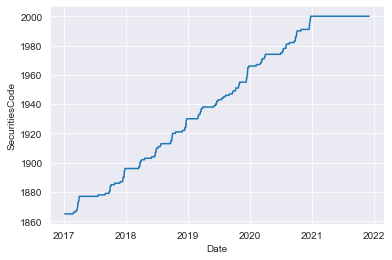

In [160]:
sns.lineplot(idcount['Date'], idcount['SecuritiesCode'])
plt.xlabel('Date')
plt.show()

In [161]:
print(stock_prices['Date'].max())
print(stock_prices['Date'].min())

2021-12-03 00:00:00
2017-01-04 00:00:00


<AxesSubplot:>

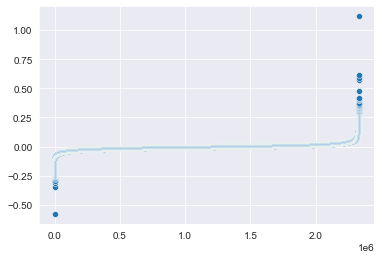

In [162]:
sns.scatterplot(range(stock_prices.shape[0]), np.sort(stock_prices['Target']))

Most of targets are close to 0, with some outliers

## Looking at Close Values of some Stocks

In [163]:
stock_prices['SecuritiesCode'].value_counts().head()

1301    1202
7282    1202
7414    1202
7412    1202
7408    1202
Name: SecuritiesCode, dtype: int64

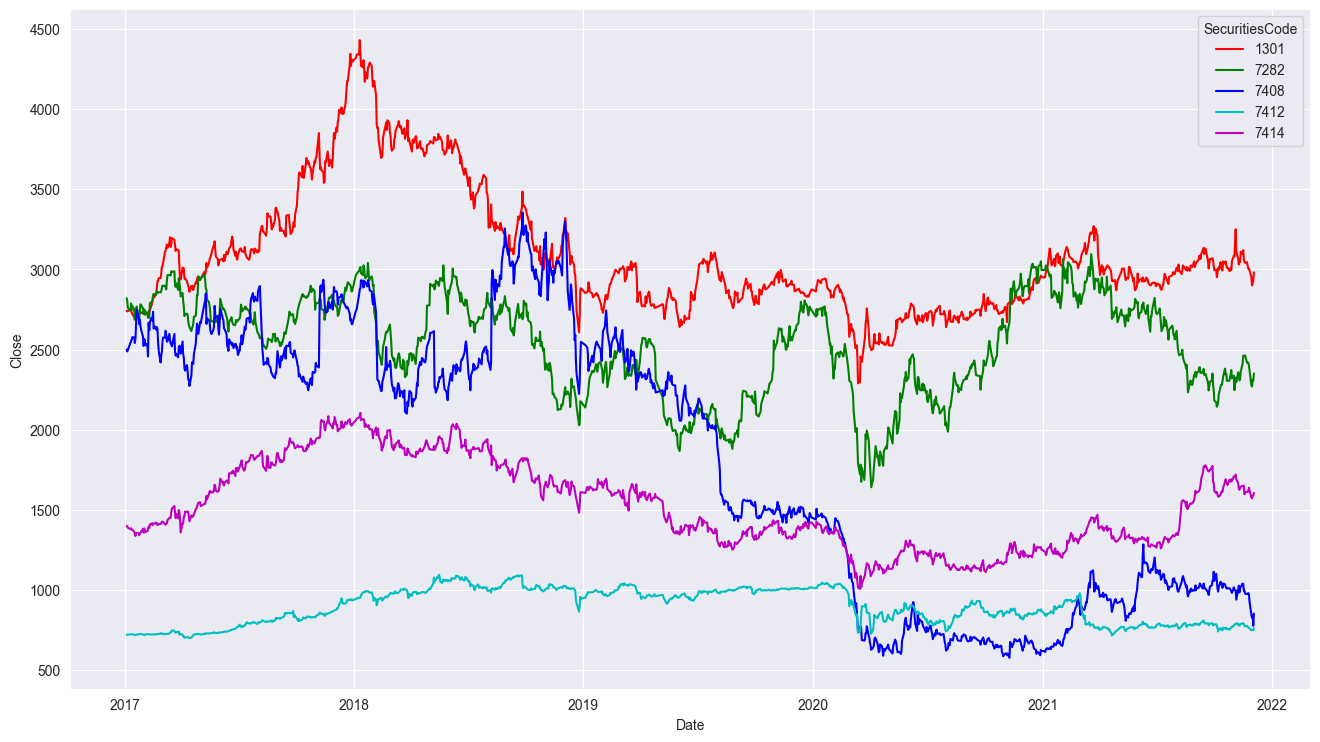

In [164]:
seclist = [1301, 7282, 7414, 7412, 7408]
stock_prices_copy = stock_prices.copy()
stock_prices_copy = stock_prices_copy[stock_prices_copy['SecuritiesCode'].isin(seclist)]

plt.figure(figsize=(16,9), dpi=100)
line = sns.lineplot(stock_prices_copy['Date'], stock_prices_copy['Close'], hue = stock_prices_copy['SecuritiesCode'], palette=['r','g','b','c','m'])

plt.show()

##  CREATING MODEL

Testing with DecisionTreeRegressor, will have to change to ARIMA or another forecasting model.

In [165]:
stock_prices_simple = stock_prices[~stock_prices['Target'].isnull()]
stock_prices_simple = stock_prices_simple[stock_prices_simple['Date'] >="2021-10-01"]
feats = ['SecuritiesCode','Open','High','Low','Close','Volume','AdjustmentFactor','ExpectedDividend','SupervisionFlag']
stock_prices_target = stock_prices_simple['Target']
stock_prices_simple = stock_prices_simple[feats]
stock_prices_simple.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88000 entries, 2244531 to 2332530
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SecuritiesCode    88000 non-null  int64  
 1   Open              87715 non-null  float64
 2   High              87715 non-null  float64
 3   Low               87715 non-null  float64
 4   Close             87715 non-null  float64
 5   Volume            88000 non-null  int64  
 6   AdjustmentFactor  88000 non-null  float64
 7   ExpectedDividend  98 non-null     float64
 8   SupervisionFlag   88000 non-null  bool   
dtypes: bool(1), float64(6), int64(2)
memory usage: 6.1 MB


In [166]:
stock_prices_simple['ExpectedDividend'].fillna(0, inplace=True)
stock_prices_simple.ffill(inplace=True)
stock_prices_simple.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88000 entries, 2244531 to 2332530
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SecuritiesCode    88000 non-null  int64  
 1   Open              88000 non-null  float64
 2   High              88000 non-null  float64
 3   Low               88000 non-null  float64
 4   Close             88000 non-null  float64
 5   Volume            88000 non-null  int64  
 6   AdjustmentFactor  88000 non-null  float64
 7   ExpectedDividend  88000 non-null  float64
 8   SupervisionFlag   88000 non-null  bool   
dtypes: bool(1), float64(6), int64(2)
memory usage: 6.1 MB


In [167]:
X_test = pd.read_csv('supplemental_files/secondary_stock_prices.csv')
X_test = X_test[feats]
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118450 entries, 0 to 118449
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   SecuritiesCode    118450 non-null  int64  
 1   Open              114688 non-null  float64
 2   High              114688 non-null  float64
 3   Low               114688 non-null  float64
 4   Close             114688 non-null  float64
 5   Volume            118450 non-null  int64  
 6   AdjustmentFactor  118450 non-null  float64
 7   ExpectedDividend  717 non-null     float64
 8   SupervisionFlag   118450 non-null  bool   
dtypes: bool(1), float64(6), int64(2)
memory usage: 7.3 MB


In [168]:
X_test['ExpectedDividend'].fillna(0, inplace =True)
X_test.ffill(inplace = True)
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118450 entries, 0 to 118449
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   SecuritiesCode    118450 non-null  int64  
 1   Open              118450 non-null  float64
 2   High              118450 non-null  float64
 3   Low               118450 non-null  float64
 4   Close             118450 non-null  float64
 5   Volume            118450 non-null  int64  
 6   AdjustmentFactor  118450 non-null  float64
 7   ExpectedDividend  118450 non-null  float64
 8   SupervisionFlag   118450 non-null  bool   
dtypes: bool(1), float64(6), int64(2)
memory usage: 7.3 MB


In [169]:
model = DecisionTreeRegressor()
model.fit(stock_prices_simple,stock_prices_target)
model.score(stock_prices_simple, stock_prices_target)
model.predict(X_test)


array([-0.00643883,  0.01974001, -0.0177665 , ..., -0.01518987,
       -0.01203209, -0.09560327])

In [170]:
check = pd.read_csv('supplemental_files/secondary_stock_prices.csv')
check['Target'].head

<bound method NDFrame.head of 0         0.005013
1         0.005793
2         0.005367
3         0.005927
4         0.006300
            ...   
118445   -0.008000
118446   -0.006312
118447   -0.002257
118448   -0.004345
118449    0.001520
Name: Target, Length: 118450, dtype: float64>

Innacurate values, will need better model